<a href="https://colab.research.google.com/github/skamranh/big-data-final/blob/main/CHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
- https://www.kaggle.com/datasets/captainozlem/framingham-chd-preprocessed-data

In [1]:
!pip install pyspark
!pip install -q findspark

import pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
import pyspark.pandas as ps

spark = SparkSession.builder.appName('wine').getOrCreate()

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
dataset_loc = "data/CHD_preprocessed.csv"
chd_spark = spark.read.csv(dataset_loc, header="true", inferSchema=True)
chd_pd = pd.read_csv(dataset_loc)
chd_ps = ps.read_csv(dataset_loc)

In [4]:
chd_ps.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,1,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
chd_spark.schema

StructType(List(StructField(male,IntegerType,true),StructField(age,IntegerType,true),StructField(education,IntegerType,true),StructField(currentSmoker,IntegerType,true),StructField(cigsPerDay,DoubleType,true),StructField(BPMeds,DoubleType,true),StructField(prevalentStroke,IntegerType,true),StructField(prevalentHyp,IntegerType,true),StructField(diabetes,IntegerType,true),StructField(totChol,DoubleType,true),StructField(sysBP,DoubleType,true),StructField(diaBP,DoubleType,true),StructField(BMI,DoubleType,true),StructField(heartRate,DoubleType,true),StructField(glucose,DoubleType,true),StructField(TenYearCHD,IntegerType,true)))

In [6]:
chd_ps.shape

(4133, 16)

In [7]:
chd_ps.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 4133 entries, 0 to 4132
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4133 non-null   int32  
 1   age              4133 non-null   int32  
 2   education        4133 non-null   int32  
 3   currentSmoker    4133 non-null   int32  
 4   cigsPerDay       4133 non-null   float64
 5   BPMeds           4133 non-null   float64
 6   prevalentStroke  4133 non-null   int32  
 7   prevalentHyp     4133 non-null   int32  
 8   diabetes         4133 non-null   int32  
 9   totChol          4133 non-null   float64
 10  sysBP            4133 non-null   float64
 11  diaBP            4133 non-null   float64
 12  BMI              4133 non-null   float64
 13  heartRate        4133 non-null   float64
 14  glucose          4133 non-null   float64
 15  TenYearCHD       4133 non-null   int32  
dtypes: float64(8), int32(8)

<AxesSubplot:>

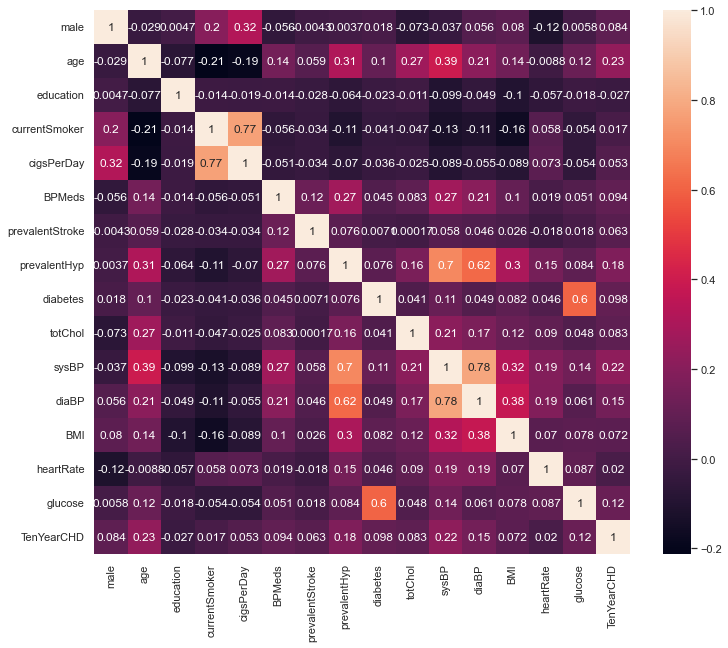

In [8]:
plt.rcParams['figure.figsize'] = [12, 10]
sns.set(font_scale = 1)
sns.heatmap(chd_pd.corr(), annot = True)

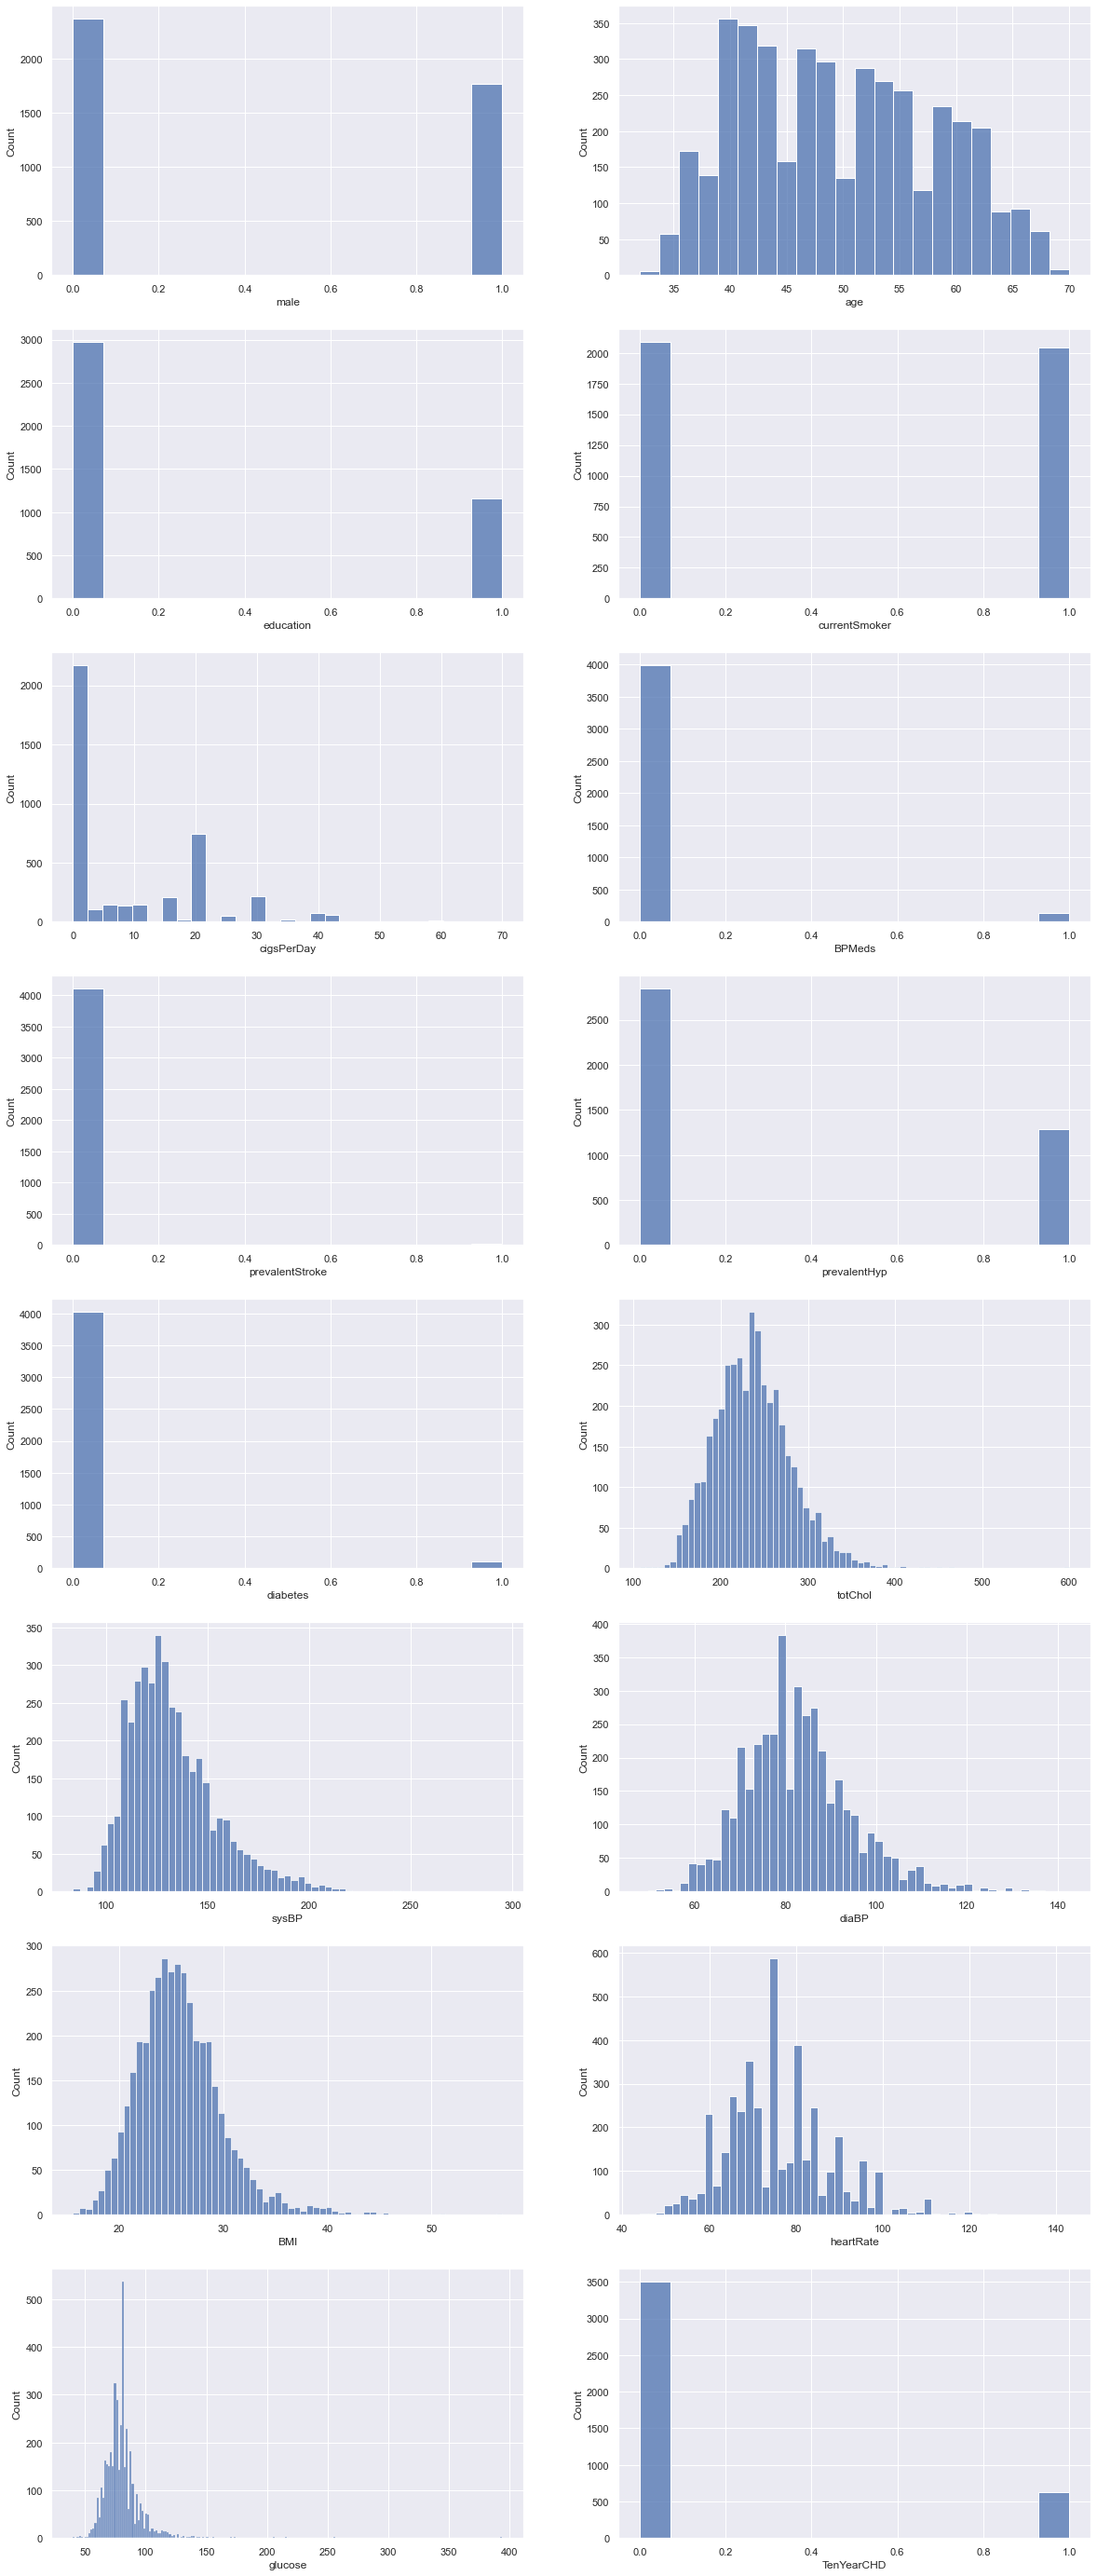

In [9]:
plt.rcParams['figure.figsize'] = [20, 50]
for i, column in enumerate(chd_pd.columns, 1):
    plt.subplot(8,2,i)
    sns.histplot(chd_pd[column])

# Distribution Analysis
- cigPerDay is skewed for 0, since most of the subjects didn't smoke at all. This may produce a bias for non smokers(although smoking can increase heart related issues GK:)).
- BPmeds and PrevelantStroke data are too skewed for 0 and final model will get biased so it might be best to not include them in the model.
- Diabetes is skewed as well, but can be used(need to keep an eye on the model.)
- TenYearCHD is our target variable and is biased for 0, this is not good for the final model and F1,Precision must be used instead of accuracy.

In [37]:
feature_columns = chd_spark.columns[:-1] # here we omit the final column
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

#Feature Selection
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
chd_spark2 = assembler.transform(chd_spark)
# chd_spark2.show()

#Split
train, test = chd_spark2.randomSplit([0.7, 0.3])

#model Definition
algo = LogisticRegression(
    featuresCol="features", 
    labelCol="TenYearCHD",
    maxIter=10)

#Training
model = algo.fit(train)

#Evaluation
training_summary = model.evaluate(train) 
evaluation_summary = model.evaluate(test)
str(evaluation_summary)

'<pyspark.ml.classification.BinaryLogisticRegressionSummary object at 0x0000027E385D3EB0>'

In [38]:
# evaluation_summary.meanAbsoluteError
# evaluation_summary.rootMeanSquaredError
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
print("Accuracy(Test): " + str(training_summary.accuracy))
print("Accuracy(Test): " + str(evaluation_summary.accuracy))

Coefficients: [0.5495633161594624,0.06412935625700472,0.03388574717861189,-0.016094332830211496,0.020335592058374072,0.19113157862415117,0.7755089709000537,0.2092593839149398,-0.04015402953669284,0.0015733605900402708,0.016323226744762512,-0.0038750727912578034,-0.006340293316660149,-0.004001668754106162,0.007665609441996041]
Intercept: -7.990702101716403
Accuracy(Test): 0.8622848200312989


In [39]:
predictions = model.transform(test)

In [40]:
trainingSummary = model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
model.setThreshold(bestThreshold)

objectiveHistory:
0.4315669870088111
0.39654980353412356
0.3899617164996452
0.3828555781014193
0.3823240242104128
0.3822119895716153
0.38217092961461224
0.3821284264940144
0.38212248340655064
0.3821205667785777
0.3821202502882684
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.004514672686230248|
|4.145936981757877...|0.006772009029345372|
|4.145936981757877...|0.011286681715575621|
|4.145936981757877...| 0.01580135440180587|
|4.145936981757877...|0.020316027088036117|
|4.145936981757877...|0.024830699774266364|
|4.145936981757877...|0.029345372460496615|
|8.291873963515755E-4| 0.03160270880361174|
|8.291873963515755E-4| 0.03611738148984198|
|8.291873963515755E-4|0.040632054176072234|
|8.291873963515755E-4|0.045146726862302484|
|0.001658374792703151|0.045146726862302484|
|0.002072968490878...| 0.04740406320541761|
|0.002487562189054...|

LogisticRegressionModel: uid=LogisticRegression_47063c8f9b09, numClasses=2, numFeatures=15